In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [4]:
# Load data
df = pd.read_csv("/Users/mariahloehr/IICD/IICD/Data/cell_cycle_tidied.csv")

# Combine phase M and G2 into one class
df['phase'] = df['phase'].replace({'M': 'G2'})

# Separate features and target
X = df.drop(columns=['phase', 'age', 'PHATE_1', 'PHATE_2'])
y = df['phase']

# Split data into train and test sets (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=949, stratify=y)

In [ ]:
## hypertuning

rf = RandomForestClassifier(n_estimators=500, max_depth=50, max_features='sqrt', random_state=949)

param_grid = {
    'n_estimators': [500],              
    'max_depth': [50],
    'max_features': [200, 250]          
}

# Set up GridSearch with 10-fold cross-validation optimizing for accuracy
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=10,
    scoring='accuracy',
    n_jobs=-1
)

# Fit the model to your data
grid_search.fit(X_train, y_train)

#Output best settings and best accuracy
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

In [ ]:
# OOB error 
# Define the values of max_features to test
max_features_options = [250, None]  # Try 3–5 reasonable values

oob_results = {}

# Loop over different max_features
for mf in max_features_options:
    rf = RandomForestClassifier(
        n_estimators=500,
        max_depth=50,
        max_features=mf,
        oob_score=True,
        bootstrap=True,
        random_state=949,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    oob_results[mf] = rf.oob_score_

# Show OOB results
print("=== OOB Scores by max_features ===")
for mf, score in oob_results.items():
    print(f"max_features={mf}: OOB Accuracy = {score:.4f}")

# Choose best setting
best_mf = max(oob_results, key=oob_results.get)
print(f"\nBest max_features based on OOB: {best_mf}")

=== OOB Scores by max_features ===
max_features=250: OOB Accuracy = 0.9774
max_features=None: OOB Accuracy = 0.9777

Best max_features based on OOB: None


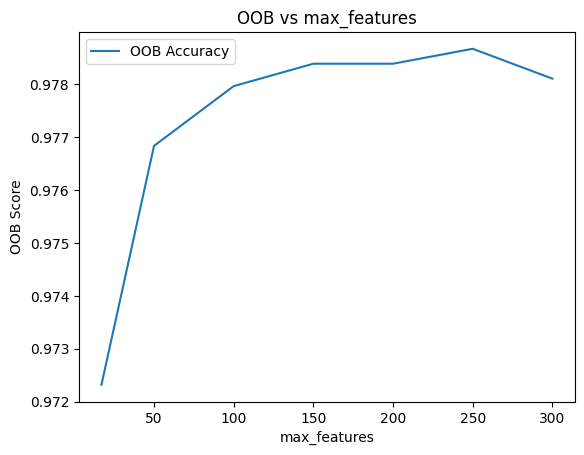

In [ ]:
## OOB plot
max_features_range = [17, 50, 100, 150, 200, 250, 300]  # example for 300 features
oob_scores = []

for mf in max_features_range:
    rf = RandomForestClassifier(
        n_estimators=600,
        max_depth=50,
        max_features=mf,
        oob_score=True,
        random_state=42,
        bootstrap=True
    )
    rf.fit(X_train, y_train)
    
    oob_scores.append(rf.oob_score_)

plt.plot(max_features_range, oob_scores, label="OOB Accuracy")
plt.xlabel("max_features")
plt.ylabel("OOB Score")
plt.title("OOB vs max_features")
plt.legend()
plt.show()

In [3]:
# retrain model
rf = RandomForestClassifier(n_estimators=500, max_depth=50, max_features=250, random_state=949)
rf.fit(X_train, y_train)

# Predict on training and test sets
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

In [ ]:
# Output results

print("=== Training Set ===")
print("Overall Accuracy:", accuracy_score(y_train, y_train_pred))

print("\n=== Test Set ===")
print("Overall Accuracy:", accuracy_score(y_test, y_test_pred))

# For training set
df_train = pd.DataFrame({'true': y_train, 'pred': y_train_pred})
accuracy_per_phase_train = df_train.groupby('true').apply(lambda x: accuracy_score(x['true'], x['pred']))

print("Accuracy per phase (Train):")
print(accuracy_per_phase_train)

# For test set
df_test = pd.DataFrame({'true': y_test, 'pred': y_test_pred})
accuracy_per_phase_test = df_test.groupby('true').apply(lambda x: accuracy_score(x['true'], x['pred']))

print("\nAccuracy per phase (Test):")
print(accuracy_per_phase_test)

print("Test Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred, labels = ["G0", "G1", "G2", "S"]))

=== Training Set ===
Overall Accuracy: 1.0

=== Test Set ===
Overall Accuracy: 0.9745762711864406
Accuracy per phase (Train):
true
G0    1.0
G1    1.0
G2    1.0
S     1.0
dtype: float64

Accuracy per phase (Test):
true
G0    1.000000
G1    0.977918
G2    0.962185
S     0.958095
dtype: float64
Test Confusion Matrix
[[373   0   0   0]
 [  0 620   0  14]
 [  0   0 229   9]
 [  0  10  12 503]]


/var/folders/1s/bvxr71hj0hqgyk_jk6k7wkm80000gn/T/ipykernel_20636/1409912062.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_per_phase_train = df_train.groupby('true').apply(lambda x: accuracy_score(x['true'], x['pred']))
/var/folders/1s/bvxr71hj0hqgyk_jk6k7wkm80000gn/T/ipykernel_20636/1409912062.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_per_phase_test = df_test.groupby('true').apply(

In [ ]:
# save results
# === Load existing results ===
results_df = pd.read_csv("/Users/mariahloehr/IICD/IICD/Bar Plot/classification_results.csv", index_col=0)

# === Compute accuracy ===
from sklearn.metrics import accuracy_score

overall_acc = accuracy_score(y_test, y_test_pred)

df_test = pd.DataFrame({'true': y_test, 'pred': y_test_pred})
acc_per_phase = df_test.groupby('true').apply(lambda x: accuracy_score(x['true'], x['pred']))

# === Insert values ===
model_name = "RF (full)"
results_df.loc[model_name, 'Overall'] = overall_acc

# Set per-phase accuracies
for phase in ['G0', 'G1', 'G2', 'S']:
    if phase in acc_per_phase.index:
        results_df.loc[model_name, phase] = acc_per_phase[phase]

# === Save updated file ===
results_df.to_csv("/Users/mariahloehr/IICD/IICD/Bar Plot/classification_results.csv")

/var/folders/1s/bvxr71hj0hqgyk_jk6k7wkm80000gn/T/ipykernel_20636/1441370449.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_per_phase = df_test.groupby('true').apply(lambda x: accuracy_score(x['true'], x['pred']))


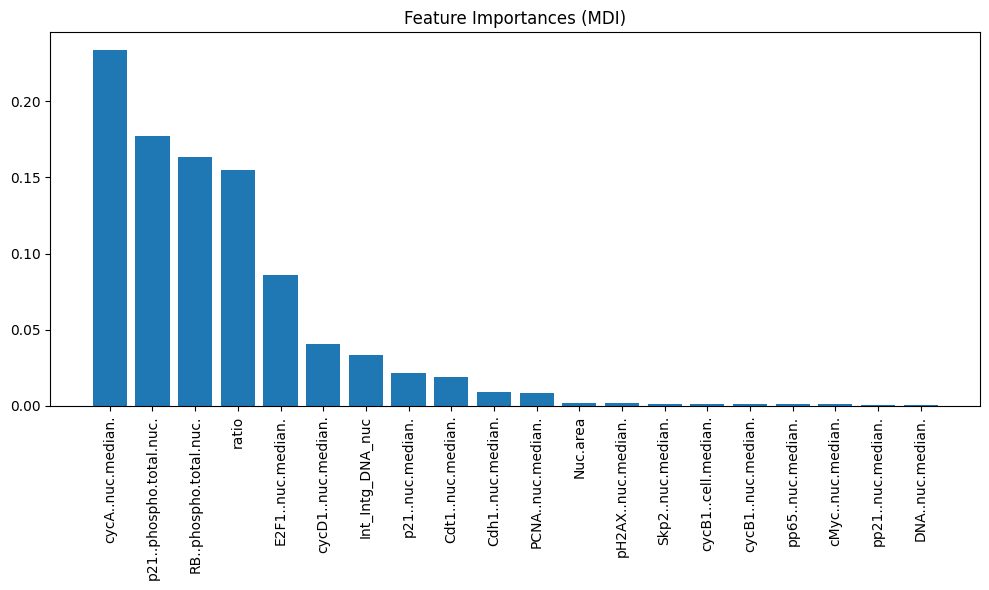

                     Feature  MDI Importance
1          cycA..nuc.median.        0.233743
241  p21..phospho.total.nuc.        0.177222
239   RB..phospho.total.nuc.        0.163370
261                    ratio        0.154832
0          E2F1..nuc.median.        0.086181
..                       ...             ...
169           S6..PN.median.        0.000054
213         pp38..PN.median.        0.000054
149       pp38..cyto.median.        0.000053
175        DNA..cyto.median.        0.000051
123          DNA..PN.median.        0.000047

[262 rows x 2 columns]


In [ ]:
# Get feature importances (MDI)
importances = rf.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]  # Sort by importance descending

# Select top n indices
top_n = 20
top_indices = indices[:top_n]

# Plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (MDI)")
plt.bar(range(top_n), importances[top_indices], align='center')
plt.xticks(range(top_n), feature_names[top_indices], rotation=90)
plt.tight_layout()
plt.show()

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'MDI Importance': importances
}).sort_values(by='MDI Importance', ascending=False)

print(importance_df)

<Axes: title={'center': 'Random Forest MDI (Top 20)'}>

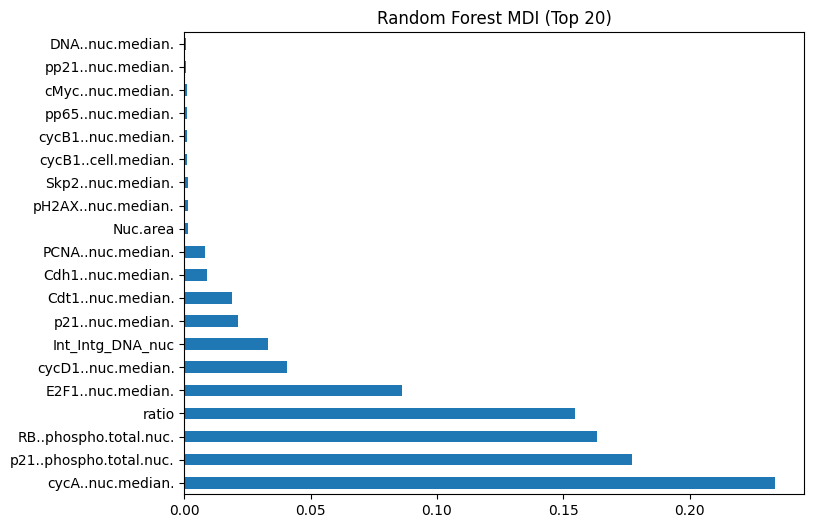

In [6]:
# Extract MDI importances
rf_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
rf_importances_sorted = rf_importances.sort_values(ascending=False)

# Top features
rf_importances_sorted.head(20).plot(kind='barh', figsize=(8, 6), title='Random Forest MDI (Top 20)')